# Baseline Comparison: Text-Only Model vs Baselines

This notebook trains a simple text-only transformer model and compares it with three baselines:
1. Global mean predictor
2. Per-user mean predictor  
3. Persistence/lag baseline


In [32]:
# Install dependencies
%pip install torch transformers pandas numpy scikit-learn matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random

# Configuration - Optimized for speed
DATA_PATH = 'TRAIN_RELEASE_3SEP2025/train_subtask1.csv'
EPOCHS = 10  # Reduced for faster training
BATCH_SIZE = 128  # Increased for faster training
MAX_LENGTH = 64  # Reduced for faster processing
LEARNING_RATE = 2e-5
MODEL_NAME = 'distilbert-base-uncased'
NORMALIZE = 'zscore'
USE_AMP = torch.cuda.is_available()  # Only use AMP on GPU
NUM_WORKERS = 0  # Faster on Windows, avoids multiprocessing overhead

# Random seed
RANDOM_SEED = random.randint(0, 10000)
print(f"Using random seed: {RANDOM_SEED}")

# Set all random seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using random seed: 5637
Using device: cpu


## Model Definition (Text-Only, No Temporal Features)


In [34]:
class AffectRegressor(nn.Module):
    """Simple text-only transformer-based regression model."""
    
    def __init__(self, model_name='distilbert-base-uncased', dropout=0.1, freeze_encoder=False):
        super(AffectRegressor, self).__init__()
        
        # Load pretrained transformer
        self.encoder = AutoModel.from_pretrained(model_name)
        
        # Freeze encoder if requested
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        
        hidden_size = self.encoder.config.hidden_size
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 2)  # [valence, arousal]
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_representation = outputs.last_hidden_state[:, 0, :]
        predictions = self.regressor(cls_representation)
        return predictions

def get_model_and_tokenizer(model_name='distilbert-base-uncased', freeze_encoder=False):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    model = AffectRegressor(model_name=model_name, freeze_encoder=freeze_encoder)
    return model, tokenizer


In [35]:
class AffectDataset(Dataset):
    """Dataset for text-only affect prediction."""
    
    def __init__(self, texts, valences, arousals, tokenizer, max_length=96, 
                 normalize='zscore', scaler_valence=None, scaler_arousal=None):
        self.texts = texts
        self.valences = np.array(valences)
        self.arousals = np.array(arousals)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Normalize targets
        if scaler_valence is None or scaler_arousal is None:
            if normalize == 'zscore':
                self.scaler_valence = StandardScaler()
                self.scaler_arousal = StandardScaler()
            else:
                raise ValueError(f"Unknown normalization: {normalize}")
            self.valences = self.scaler_valence.fit_transform(self.valences.reshape(-1, 1)).flatten()
            self.arousals = self.scaler_arousal.fit_transform(self.arousals.reshape(-1, 1)).flatten()
        else:
            self.scaler_valence = scaler_valence
            self.scaler_arousal = scaler_arousal
            self.valences = self.scaler_valence.transform(self.valences.reshape(-1, 1)).flatten()
            self.arousals = self.scaler_arousal.transform(self.arousals.reshape(-1, 1)).flatten()
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'valence': torch.tensor(self.valences[idx], dtype=torch.float32),
            'arousal': torch.tensor(self.arousals[idx], dtype=torch.float32)
        }


In [36]:
# Load data
df = pd.read_csv(DATA_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

print(f"Loaded {len(df)} samples")
print(f"Unique users: {df['user_id'].nunique()}")

# Split into train and validation
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=RANDOM_SEED, shuffle=True
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}")

# Get Model 1 and tokenizer (freeze encoder for faster training)
model, tokenizer = get_model_and_tokenizer(MODEL_NAME, freeze_encoder=True)
model = model.to(device)

# Create datasets (with user_ids for potential Model 2 use)
train_dataset = AffectDataset(
    texts=train_df['text'].tolist(),
    valences=train_df['valence'].tolist(),
    arousals=train_df['arousal'].tolist(),
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    normalize=NORMALIZE,
)

scaler_valence = train_dataset.scaler_valence
scaler_arousal = train_dataset.scaler_arousal

val_dataset = AffectDataset(
    texts=val_df['text'].tolist(),
    valences=val_df['valence'].tolist(),
    arousals=val_df['arousal'].tolist(),
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    normalize=NORMALIZE,
    scaler_valence=scaler_valence,
    scaler_arousal=scaler_arousal,
)

# Create dataloaders (simplified for speed)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


Loaded 2764 samples
Unique users: 137
Train: 2211, Val: 553


## Baseline Implementations


In [37]:
def compute_metrics(pred_v, true_v, pred_a, true_a):
    """Compute metrics including correlation, MAE, and RAE."""
    mse_v = np.mean((pred_v - true_v) ** 2)
    mse_a = np.mean((pred_a - true_a) ** 2)
    mae_v = np.mean(np.abs(pred_v - true_v))
    mae_a = np.mean(np.abs(pred_a - true_a))
    
    # RAE (Relative Absolute Error)
    rae_v = mae_v / (np.mean(np.abs(true_v)) + 1e-8)
    rae_a = mae_a / (np.mean(np.abs(true_a)) + 1e-8)
    
    # R²
    ss_res_v = np.sum((true_v - pred_v) ** 2)
    ss_tot_v = np.sum((true_v - np.mean(true_v)) ** 2)
    r2_v = 1 - (ss_res_v / (ss_tot_v + 1e-8))
    
    ss_res_a = np.sum((true_a - pred_a) ** 2)
    ss_tot_a = np.sum((true_a - np.mean(true_a)) ** 2)
    r2_a = 1 - (ss_res_a / (ss_tot_a + 1e-8))
    
    # Pearson correlation (handle zero variance case)
    if len(pred_v) > 1:
        if np.std(pred_v) > 1e-8 and np.std(true_v) > 1e-8:
            corr_v = np.corrcoef(pred_v, true_v)[0, 1]
        else:
            corr_v = 0.0
    else:
        corr_v = 0.0
    
    if len(pred_a) > 1:
        if np.std(pred_a) > 1e-8 and np.std(true_a) > 1e-8:
            corr_a = np.corrcoef(pred_a, true_a)[0, 1]
        else:
            corr_a = 0.0
    else:
        corr_a = 0.0
    
    return {
        'valence_mse': mse_v, 'arousal_mse': mse_a,
        'valence_mae': mae_v, 'arousal_mae': mae_a,
        'valence_rae': rae_v, 'arousal_rae': rae_a,
        'valence_r2': r2_v, 'arousal_r2': r2_a,
        'valence_corr': corr_v, 'arousal_corr': corr_a
    }

# Baseline 1: Global Mean Predictor
def global_mean_baseline(train_df, val_df):
    """Predict global mean from training set."""
    mean_v = train_df['valence'].mean()
    mean_a = train_df['arousal'].mean()
    
    pred_v = np.full(len(val_df), mean_v)
    pred_a = np.full(len(val_df), mean_a)
    true_v = val_df['valence'].values
    true_a = val_df['arousal'].values
    
    return compute_metrics(pred_v, true_v, pred_a, true_a)

# Baseline 2: Per-User Mean Predictor
def per_user_mean_baseline(train_df, val_df):
    """For seen users: use their training mean. For unseen: use global mean."""
    global_mean_v = train_df['valence'].mean()
    global_mean_a = train_df['arousal'].mean()
    
    # Compute per-user means from training
    user_means = train_df.groupby('user_id')[['valence', 'arousal']].mean()
    train_users = set(train_df['user_id'].unique())
    
    pred_v = []
    pred_a = []
    true_v = []
    true_a = []
    
    for _, row in val_df.iterrows():
        user_id = row['user_id']
        if user_id in train_users:
            pred_v.append(user_means.loc[user_id, 'valence'])
            pred_a.append(user_means.loc[user_id, 'arousal'])
        else:
            pred_v.append(global_mean_v)
            pred_a.append(global_mean_a)
        true_v.append(row['valence'])
        true_a.append(row['arousal'])
    
    return compute_metrics(np.array(pred_v), np.array(true_v), 
                          np.array(pred_a), np.array(true_a))

# Baseline 3: Persistence/Lag Baseline
def persistence_baseline(train_df, val_df):
    """Predict previous value. For first entry per user, use their training mean or global mean."""
    global_mean_v = train_df['valence'].mean()
    global_mean_a = train_df['arousal'].mean()
    
    user_means = train_df.groupby('user_id')[['valence', 'arousal']].mean()
    train_users = set(train_df['user_id'].unique())
    
    # Store last values per user
    last_values = {}
    for user_id in train_users:
        user_train = train_df[train_df['user_id'] == user_id].sort_values('timestamp')
        if len(user_train) > 0:
            last_values[user_id] = {
                'valence': user_train.iloc[-1]['valence'],
                'arousal': user_train.iloc[-1]['arousal']
            }
    
    pred_v = []
    pred_a = []
    true_v = []
    true_a = []
    
    val_df_sorted = val_df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)
    
    for _, row in val_df_sorted.iterrows():
        user_id = row['user_id']
        if user_id in last_values:
            pred_v.append(last_values[user_id]['valence'])
            pred_a.append(last_values[user_id]['arousal'])
            # Update for next prediction
            last_values[user_id] = {'valence': row['valence'], 'arousal': row['arousal']}
        elif user_id in train_users:
            # First entry for seen user, use their training mean
            pred_v.append(user_means.loc[user_id, 'valence'])
            pred_a.append(user_means.loc[user_id, 'arousal'])
            last_values[user_id] = {'valence': row['valence'], 'arousal': row['arousal']}
        else:
            # Unseen user, use global mean
            pred_v.append(global_mean_v)
            pred_a.append(global_mean_a)
            last_values[user_id] = {'valence': row['valence'], 'arousal': row['arousal']}
        
        true_v.append(row['valence'])
        true_a.append(row['arousal'])
    
    return compute_metrics(np.array(pred_v), np.array(true_v), 
                          np.array(pred_a), np.array(true_a))


In [38]:
# Compute baseline metrics
print("Computing baseline metrics...")
baseline_global = global_mean_baseline(train_df, val_df)
baseline_per_user = per_user_mean_baseline(train_df, val_df)
baseline_persistence = persistence_baseline(train_df, val_df)

print("\n=== Baseline Results ===")
print(f"Global Mean:")
print(f"  Valence - Corr: {baseline_global['valence_corr']:.4f}, MAE: {baseline_global['valence_mae']:.4f}, RAE: {baseline_global['valence_rae']:.4f}")
print(f"  Arousal - Corr: {baseline_global['arousal_corr']:.4f}, MAE: {baseline_global['arousal_mae']:.4f}, RAE: {baseline_global['arousal_rae']:.4f}")
print(f"Per-User Mean:")
print(f"  Valence - Corr: {baseline_per_user['valence_corr']:.4f}, MAE: {baseline_per_user['valence_mae']:.4f}, RAE: {baseline_per_user['valence_rae']:.4f}")
print(f"  Arousal - Corr: {baseline_per_user['arousal_corr']:.4f}, MAE: {baseline_per_user['arousal_mae']:.4f}, RAE: {baseline_per_user['arousal_rae']:.4f}")
print(f"Persistence:")
print(f"  Valence - Corr: {baseline_persistence['valence_corr']:.4f}, MAE: {baseline_persistence['valence_mae']:.4f}, RAE: {baseline_persistence['valence_rae']:.4f}")
print(f"  Arousal - Corr: {baseline_persistence['arousal_corr']:.4f}, MAE: {baseline_persistence['arousal_mae']:.4f}, RAE: {baseline_persistence['arousal_rae']:.4f}")


Computing baseline metrics...

=== Baseline Results ===
Global Mean:
  Valence - Corr: 0.0000, MAE: 1.0432, RAE: 1.0470
  Arousal - Corr: 0.0000, MAE: 0.6722, RAE: 0.8935
Per-User Mean:
  Valence - Corr: 0.4834, MAE: 0.8525, RAE: 0.8556
  Arousal - Corr: 0.4112, MAE: 0.5731, RAE: 0.7618
Persistence:
  Valence - Corr: 0.2866, MAE: 1.0818, RAE: 1.0857
  Arousal - Corr: 0.2206, MAE: 0.6442, RAE: 0.8564


## Model Training


In [39]:
# Loss and optimizer (only train unfrozen parameters)
criterion = nn.MSELoss()
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(trainable_params, lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler() if USE_AMP else None

# Track metrics per epoch
epoch_metrics = {
    'valence_corr': [], 'arousal_corr': [],
    'valence_mae': [], 'arousal_mae': [],
    'valence_rae': [], 'arousal_rae': []
}


In [40]:
def train_epoch(model, train_loader, criterion, optimizer, device, scaler=None, use_user_emb=False):
    """Train for one epoch (simplified)."""
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        valence = batch['valence'].to(device)
        arousal = batch['arousal'].to(device)
        
        optimizer.zero_grad()
        if use_user_emb:
            user_ids = batch['user_id'].to(device)
            predictions = model(input_ids, attention_mask, user_ids)
        else:
            predictions = model(input_ids, attention_mask)
        targets = torch.stack([valence, arousal], dim=1)
        loss = criterion(predictions, targets)
        
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

def evaluate_model(model, val_loader, scaler_valence, scaler_arousal, device, scaler=None):
    """Evaluate model (simplified)."""
    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            valence = batch['valence'].to(device)
            arousal = batch['arousal'].to(device)
            
            predictions = model(input_ids, attention_mask)
            targets = torch.stack([valence, arousal], dim=1)
            all_preds.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    # Denormalize
    preds = np.concatenate(all_preds, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    pred_v = scaler_valence.inverse_transform(preds[:, 0:1]).flatten()
    pred_a = scaler_arousal.inverse_transform(preds[:, 1:2]).flatten()
    true_v = scaler_valence.inverse_transform(targets[:, 0:1]).flatten()
    true_a = scaler_arousal.inverse_transform(targets[:, 1:2]).flatten()
    
    metrics = compute_metrics(pred_v, true_v, pred_a, true_a)
    return metrics


In [ ]:
# Training loop
best_val_corr = -float('inf')
best_metrics = None
epoch_metrics = {
    'valence_corr': [], 'arousal_corr': [],
    'valence_mae': [], 'arousal_mae': [],
    'valence_rae': [], 'arousal_rae': []
}

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_epoch(model, train_loader, criterion, optimizer, device, scaler=scaler)
    metrics = evaluate_model(model, val_loader, scaler_valence, scaler_arousal, device, scaler=scaler)
    
    epoch_metrics['valence_corr'].append(metrics['valence_corr'])
    epoch_metrics['arousal_corr'].append(metrics['arousal_corr'])
    epoch_metrics['valence_mae'].append(metrics['valence_mae'])
    epoch_metrics['arousal_mae'].append(metrics['arousal_mae'])
    epoch_metrics['valence_rae'].append(metrics['valence_rae'])
    epoch_metrics['arousal_rae'].append(metrics['arousal_rae'])
    
    avg_corr = (metrics['valence_corr'] + metrics['arousal_corr']) / 2
    if avg_corr > best_val_corr:
        best_val_corr = avg_corr
        best_metrics = metrics.copy()
        torch.save(model.state_dict(), 'best_model1.pth')
    
    print(f"  Valence - Corr: {metrics['valence_corr']:.3f}, MAE: {metrics['valence_mae']:.3f}, RAE: {metrics['valence_rae']:.3f}")
    print(f"  Arousal - Corr: {metrics['arousal_corr']:.3f}, MAE: {metrics['arousal_mae']:.3f}, RAE: {metrics['arousal_rae']:.3f}")

# Save epoch metrics to CSV
metrics_df = pd.DataFrame({
    'epoch': list(range(1, EPOCHS + 1)),
    'valence_corr': epoch_metrics['valence_corr'],
    'arousal_corr': epoch_metrics['arousal_corr'],
    'valence_mae': epoch_metrics['valence_mae'],
    'arousal_mae': epoch_metrics['arousal_mae'],
    'valence_rae': epoch_metrics['valence_rae'],
    'arousal_rae': epoch_metrics['arousal_rae']
})
metrics_df.to_csv('model1_metrics.csv', index=False)
print(f"\nSaved epoch metrics to model1_metrics.csv")

print(f"\nBest Model:")
print(f"  Valence - Corr: {best_metrics['valence_corr']:.3f}, MAE: {best_metrics['valence_mae']:.3f}, RAE: {best_metrics['valence_rae']:.3f}")
print(f"  Arousal - Corr: {best_metrics['arousal_corr']:.3f}, MAE: {best_metrics['arousal_mae']:.3f}, RAE: {best_metrics['arousal_rae']:.3f}")

# Save metrics to CSV
metrics_df = pd.DataFrame({
    'epoch': list(range(1, EPOCHS + 1)),
    'valence_corr': epoch_metrics['valence_corr'],
    'arousal_corr': epoch_metrics['arousal_corr'],
    'valence_mae': epoch_metrics['valence_mae'],
    'arousal_mae': epoch_metrics['arousal_mae'],
    'valence_rae': epoch_metrics['valence_rae'],
    'arousal_rae': epoch_metrics['arousal_rae']
})
metrics_df.to_csv('model1_metrics.csv', index=False)
print(f"\nMetrics saved to model1_metrics.csv")


Epoch 1/10


  Valence - Corr: 0.406, MAE: 1.031, RAE: 1.035
  Arousal - Corr: 0.010, MAE: 0.671, RAE: 0.893
Epoch 2/10
  Valence - Corr: 0.528, MAE: 1.009, RAE: 1.012
  Arousal - Corr: 0.081, MAE: 0.669, RAE: 0.889
Epoch 3/10
  Valence - Corr: 0.571, MAE: 0.995, RAE: 0.998
  Arousal - Corr: 0.125, MAE: 0.668, RAE: 0.888
Epoch 4/10
  Valence - Corr: 0.592, MAE: 0.982, RAE: 0.985
  Arousal - Corr: 0.151, MAE: 0.666, RAE: 0.885
Epoch 5/10
  Valence - Corr: 0.603, MAE: 0.968, RAE: 0.971
  Arousal - Corr: 0.171, MAE: 0.663, RAE: 0.882
Epoch 6/10
  Valence - Corr: 0.610, MAE: 0.949, RAE: 0.953
  Arousal - Corr: 0.190, MAE: 0.662, RAE: 0.880
Epoch 7/10
  Valence - Corr: 0.616, MAE: 0.937, RAE: 0.940
  Arousal - Corr: 0.203, MAE: 0.660, RAE: 0.877
Epoch 8/10
  Valence - Corr: 0.619, MAE: 0.926, RAE: 0.929
  Arousal - Corr: 0.223, MAE: 0.658, RAE: 0.874
Epoch 9/10
  Valence - Corr: 0.620, MAE: 0.910, RAE: 0.914
  Arousal - Corr: 0.236, MAE: 0.656, RAE: 0.872
Epoch 10/10
  Valence - Corr: 0.621, MAE: 0.899,

## Comparison Plots: Correlation vs Epoch


Loaded metrics from model1_metrics.csv


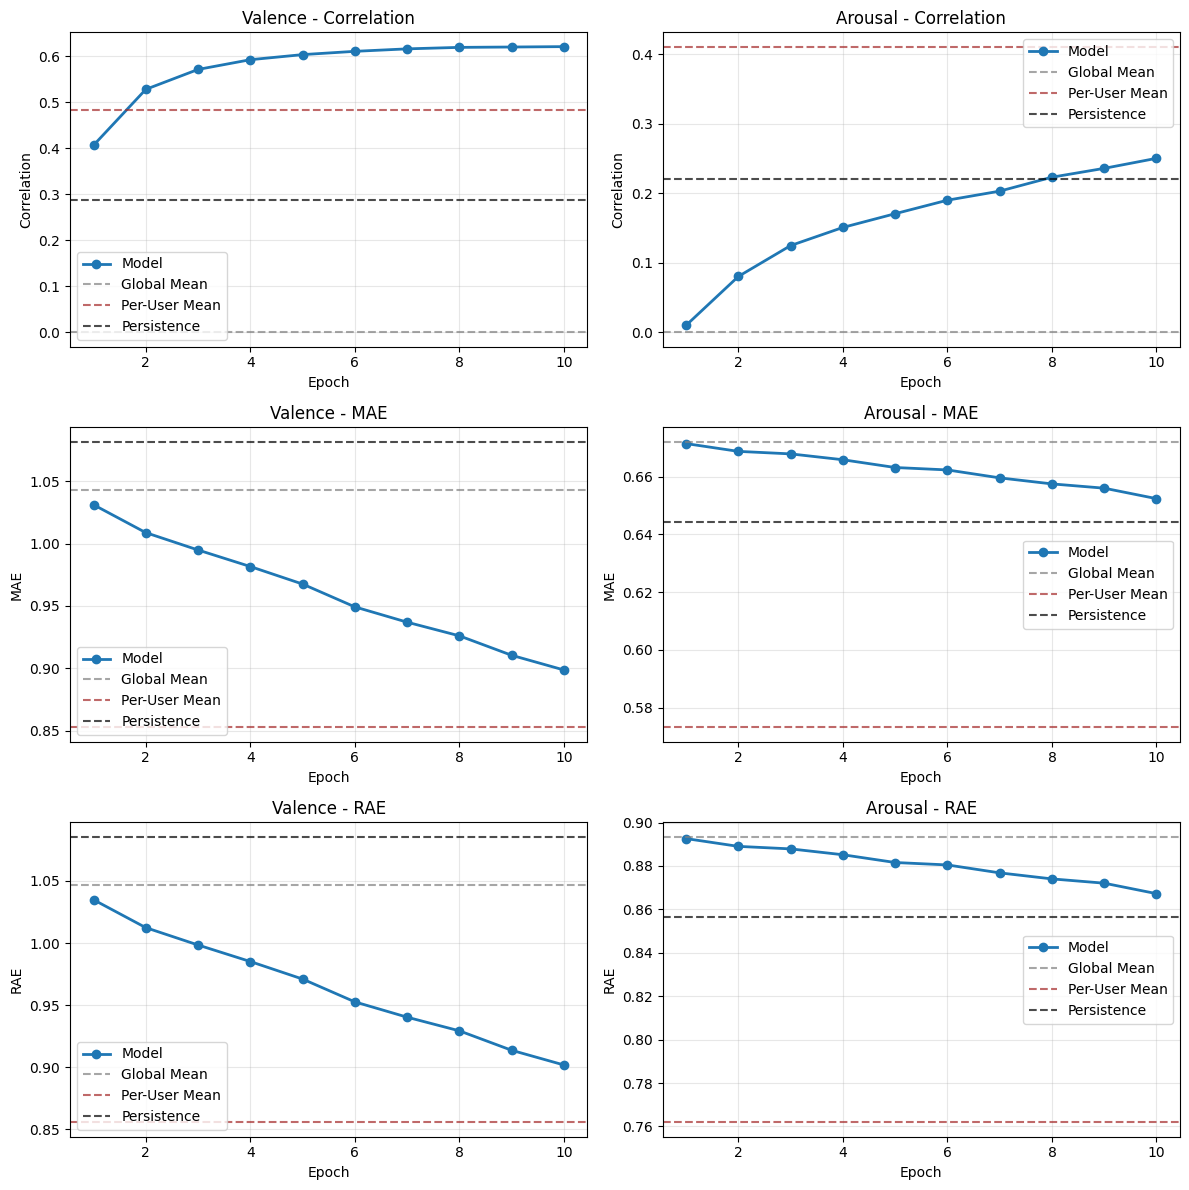


Method               Metric          Valence      Arousal     
------------------------------------------------------------
Model (Best)         Correlation     0.621        0.250       
Model (Best)         MAE             0.899        0.652       
Model (Best)         RAE             0.902        0.867       
Global Mean          Correlation     0.000        0.000       
Global Mean          MAE             1.043        0.672       
Global Mean          RAE             1.047        0.894       
Per-User Mean        Correlation     0.483        0.411       
Per-User Mean        MAE             0.853        0.573       
Per-User Mean        RAE             0.856        0.762       
Persistence          Correlation     0.287        0.221       
Persistence          MAE             1.082        0.644       
Persistence          RAE             1.086        0.856       


In [46]:
# Create comparison plots: 3 rows x 2 columns (Correlation, MAE, RAE)
# Load metrics from CSV if available, otherwise use in-memory metrics
try:
    metrics_df = pd.read_csv('model1_metrics.csv')
    epoch_metrics = {
        'valence_corr': metrics_df['valence_corr'].tolist(),
        'arousal_corr': metrics_df['arousal_corr'].tolist(),
        'valence_mae': metrics_df['valence_mae'].tolist(),
        'arousal_mae': metrics_df['arousal_mae'].tolist(),
        'valence_rae': metrics_df['valence_rae'].tolist(),
        'arousal_rae': metrics_df['arousal_rae'].tolist()
    }
    epochs = metrics_df['epoch'].tolist()
    print("Loaded metrics from model1_metrics.csv")
except FileNotFoundError:
    epochs = list(range(1, EPOCHS + 1))
    print("Using in-memory metrics")

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Row 1: Correlation
ax1, ax2 = axes[0, 0], axes[0, 1]
ax1.plot(epochs, epoch_metrics['valence_corr'], 'o-', label='Model', linewidth=2)
ax1.axhline(y=baseline_global['valence_corr'], linestyle='--', label='Global Mean', color='grey', alpha=0.7)
ax1.axhline(y=baseline_per_user['valence_corr'], linestyle='--', label='Per-User Mean', color='brown', alpha=0.7)
ax1.axhline(y=baseline_persistence['valence_corr'], linestyle='--', label='Persistence', color='black', alpha=0.7)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Correlation')
ax1.set_title('Valence - Correlation')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, epoch_metrics['arousal_corr'], 'o-', label='Model', linewidth=2)
ax2.axhline(y=baseline_global['arousal_corr'], linestyle='--', label='Global Mean', color='grey', alpha=0.7)
ax2.axhline(y=baseline_per_user['arousal_corr'], linestyle='--', label='Per-User Mean', color='brown', alpha=0.7)
ax2.axhline(y=baseline_persistence['arousal_corr'], linestyle='--', label='Persistence', color='black', alpha=0.7)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Correlation')
ax2.set_title('Arousal - Correlation')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Row 2: MAE
ax3, ax4 = axes[1, 0], axes[1, 1]
ax3.plot(epochs, epoch_metrics['valence_mae'], 'o-', label='Model', linewidth=2)
ax3.axhline(y=baseline_global['valence_mae'], linestyle='--', label='Global Mean', color='grey', alpha=0.7)
ax3.axhline(y=baseline_per_user['valence_mae'], linestyle='--', label='Per-User Mean', color='brown', alpha=0.7)
ax3.axhline(y=baseline_persistence['valence_mae'], linestyle='--', label='Persistence', color='black', alpha=0.7)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('MAE')
ax3.set_title('Valence - MAE')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.plot(epochs, epoch_metrics['arousal_mae'], 'o-', label='Model', linewidth=2)
ax4.axhline(y=baseline_global['arousal_mae'], linestyle='--', label='Global Mean', color='grey', alpha=0.7)
ax4.axhline(y=baseline_per_user['arousal_mae'], linestyle='--', label='Per-User Mean', color='brown', alpha=0.7)
ax4.axhline(y=baseline_persistence['arousal_mae'], linestyle='--', label='Persistence', color='black', alpha=0.7)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('MAE')
ax4.set_title('Arousal - MAE')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Row 3: RAE
ax5, ax6 = axes[2, 0], axes[2, 1]
ax5.plot(epochs, epoch_metrics['valence_rae'], 'o-', label='Model', linewidth=2)
ax5.axhline(y=baseline_global['valence_rae'], linestyle='--', label='Global Mean', color='grey', alpha=0.7)
ax5.axhline(y=baseline_per_user['valence_rae'], linestyle='--', label='Per-User Mean', color='brown', alpha=0.7)
ax5.axhline(y=baseline_persistence['valence_rae'], linestyle='--', label='Persistence', color='black', alpha=0.7)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('RAE')
ax5.set_title('Valence - RAE')
ax5.legend()
ax5.grid(True, alpha=0.3)

ax6.plot(epochs, epoch_metrics['arousal_rae'], 'o-', label='Model', linewidth=2)
ax6.axhline(y=baseline_global['arousal_rae'], linestyle='--', label='Global Mean', color='grey', alpha=0.7)
ax6.axhline(y=baseline_per_user['arousal_rae'], linestyle='--', label='Per-User Mean', color='brown', alpha=0.7)
ax6.axhline(y=baseline_persistence['arousal_rae'], linestyle='--', label='Persistence', color='black', alpha=0.7)
ax6.set_xlabel('Epoch')
ax6.set_ylabel('RAE')
ax6.set_title('Arousal - RAE')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary with explicit Valence/Arousal labels and MAE, RAE
print(f"\n{'Method':<20} {'Metric':<15} {'Valence':<12} {'Arousal':<12}")
print("-" * 60)
print(f"{'Model (Best)':<20} {'Correlation':<15} {best_metrics['valence_corr']:<12.3f} {best_metrics['arousal_corr']:<12.3f}")
print(f"{'Model (Best)':<20} {'MAE':<15} {best_metrics['valence_mae']:<12.3f} {best_metrics['arousal_mae']:<12.3f}")
print(f"{'Model (Best)':<20} {'RAE':<15} {best_metrics['valence_rae']:<12.3f} {best_metrics['arousal_rae']:<12.3f}")
print(f"{'Global Mean':<20} {'Correlation':<15} {baseline_global['valence_corr']:<12.3f} {baseline_global['arousal_corr']:<12.3f}")
print(f"{'Global Mean':<20} {'MAE':<15} {baseline_global['valence_mae']:<12.3f} {baseline_global['arousal_mae']:<12.3f}")
print(f"{'Global Mean':<20} {'RAE':<15} {baseline_global['valence_rae']:<12.3f} {baseline_global['arousal_rae']:<12.3f}")
print(f"{'Per-User Mean':<20} {'Correlation':<15} {baseline_per_user['valence_corr']:<12.3f} {baseline_per_user['arousal_corr']:<12.3f}")
print(f"{'Per-User Mean':<20} {'MAE':<15} {baseline_per_user['valence_mae']:<12.3f} {baseline_per_user['arousal_mae']:<12.3f}")
print(f"{'Per-User Mean':<20} {'RAE':<15} {baseline_per_user['valence_rae']:<12.3f} {baseline_per_user['arousal_rae']:<12.3f}")
print(f"{'Persistence':<20} {'Correlation':<15} {baseline_persistence['valence_corr']:<12.3f} {baseline_persistence['arousal_corr']:<12.3f}")
print(f"{'Persistence':<20} {'MAE':<15} {baseline_persistence['valence_mae']:<12.3f} {baseline_persistence['arousal_mae']:<12.3f}")
print(f"{'Persistence':<20} {'RAE':<15} {baseline_persistence['valence_rae']:<12.3f} {baseline_persistence['arousal_rae']:<12.3f}")
